# Introduction
The data was extracted from the census bureau database found at https://www.census.gov/data.html

### Objective
The main goal is to predict whether a person income level over 50K a year or not.

# Data Acquisition

In [1]:
# Import Package and Data
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.cluster.hierarchy as sch   # Used for reordering the correlation matrix

import sklearn 
%matplotlib inline

import joblib,time
from sklearn.metrics import confusion_matrix,accuracy_score,classification_report,precision_score,recall_score,roc_curve,roc_auc_score,f1_score
# grid searching key hyperparametres for logistic regression
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier

import warnings
warnings.filterwarnings('ignore')

In [2]:
#define path of data folder
data_path = 'D:/JOB PREP/Upcoming/Assessment - DS - Dataiku/Data/'
income_learn_df = pd.read_csv(data_path+"census_income_learn_processed.csv")
income_test_df = pd.read_csv(data_path+"census_income_test_processed.csv")

In [3]:
#sample data
income_learn_df.head()

,AAGE,ACLSWKR,ADTIND,ADTOCC,AHGA,AHRSPAY,AHSCOL,AMARITL,AMJIND,AMJOCC,...,PARENT,PRCITSHP,VETQVA,WKSWORK,year,Age,WorkerClass,Education,SpouseStatus,income_level
0,0.388889,0.500,0.64,0.630435,0.4375,0.0,1.0,0.333333,0.826087,0.500000,...,1.00,1.0,0.5,1.0,0.0,0.0,0.75,0.000,1.0,0
1,0.333333,0.125,0.82,0.456522,0.7500,0.0,1.0,0.333333,0.521739,0.000000,...,1.00,1.0,0.5,1.0,1.0,0.0,0.00,0.750,1.0,0
2,0.155556,0.375,0.00,0.000000,0.6250,0.0,1.0,0.666667,0.608696,0.428571,...,0.00,1.0,0.5,0.0,0.0,0.0,0.50,0.375,0.0,0
3,0.577778,0.375,0.00,0.000000,0.3750,0.0,1.0,0.333333,0.608696,0.428571,...,1.00,1.0,0.5,0.0,0.0,0.0,0.50,0.625,1.0,0
4,0.166667,0.375,0.00,0.000000,0.3125,0.0,1.0,0.666667,0.608696,0.428571,...,0.75,1.0,0.5,0.0,1.0,0.0,0.50,0.625,0.0,0


In [4]:
income_test_df.head()

,AAGE,ACLSWKR,ADTIND,ADTOCC,AHGA,AHRSPAY,AHSCOL,AMARITL,AMJIND,AMJOCC,...,PARENT,PRCITSHP,VETQVA,WKSWORK,year,Age,WorkerClass,Education,SpouseStatus,income_level
0,0.844444,0.375,0.0,0.000000,1.000,0.0,1.0,0.333333,0.608696,0.428571,...,1.0,1.0,0.5,0.0,1.0,0.0,0.5,0.625,1.0,0
1,0.355556,0.875,0.8,0.043478,0.750,0.0,1.0,0.666667,0.391304,0.142857,...,1.0,1.0,0.5,1.0,0.0,0.0,0.0,0.750,0.0,0
2,0.066667,0.375,0.0,0.000000,0.625,0.0,1.0,0.666667,0.608696,0.428571,...,0.0,1.0,0.5,0.0,1.0,0.0,0.5,0.375,0.0,0
3,0.155556,0.375,0.0,0.000000,0.625,0.0,1.0,0.666667,0.608696,0.428571,...,0.0,1.0,0.5,0.0,0.0,0.0,0.5,0.375,0.0,0
4,0.066667,0.375,0.0,0.000000,0.625,0.0,1.0,0.666667,0.608696,0.428571,...,0.0,1.0,0.5,0.0,0.0,0.0,0.5,0.375,0.0,0


In [5]:
# Shape of dataset

In [6]:
income_learn_df.shape

(24764, 33)

In [7]:
income_test_df.shape

(12372, 33)

In [8]:
#featureset
income_learn_df.columns

Index(['AAGE', 'ACLSWKR', 'ADTIND', 'ADTOCC', 'AHGA', 'AHRSPAY', 'AHSCOL',
       'AMARITL', 'AMJIND', 'AMJOCC', 'ARACE', 'AREORGN', 'ASEX', 'AUNMEM',
       'AUNTYPE', 'AWKSTAT', 'FILESTAT', 'GRINREG', 'HHDFMX', 'HHDREL',
       'MIGSAME', 'MIGSUN', 'NOEMP', 'PARENT', 'PRCITSHP', 'VETQVA', 'WKSWORK',
       'year', 'Age', 'WorkerClass', 'Education', 'SpouseStatus',
       'income_level'],
      dtype='object')

# Model Building

### Define Target

- Prediction Type: Binary Classification
- Target Variable: income_level

### Define Train and Test Dataset

In [9]:
TrainingSet = income_learn_df
TestingSet = income_test_df

X_train = TrainingSet.drop(['income_level'],axis=1)
X_test = TestingSet.drop(['income_level'],axis=1)
y_train = TrainingSet[['income_level']]
y_test = TestingSet[['income_level']]

TrainingSet.shape,TestingSet.shape

((24764, 33), (12372, 33))

### Define Metric
#### Optimization and evaluation
This metric is used both for model evaluation on the Train / Test and for hyperparameter search.
(however, if you change the metric, you’re not guaranteed that the hyperparameters are the best one for this new metric)

In [10]:
def PerformanceMetric(Model,X_train,X_test,y_train,y_test,y_pred):
    accuracy = accuracy_score(y_test,y_pred)
    precision = precision_score(y_test,y_pred)
    recall = recall_score(y_test,y_pred)
    f1 = f1_score(y_test,y_pred)
    
    print('Testing Accuracy:', round(accuracy*100,2),'%')
    print('Testing Precision:', round(precision*100,2),'%')
    print('Testing Recall:', round(recall*100,2),'%')
    print('Testing F1 Score:', round(f1*100,2),'%')
    
    #ROC curve
    fpr, tpr,threshold = roc_curve(y_test,y_pred)
    y_pred - np.rint(y_pred)
        
    #ROC AUC Curve
    roc_auc = roc_auc_score(y_test,y_pred)
    plt.figure(figsize=(15,5))
    plt.plot(fpr,tpr,label='(area = %0.2f)' % roc_auc)
    plt.plot([0,1],[0,1],'r--')
    plt.xlim([0.0,1.0])
    plt.ylim([0.0,1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc='lower right')
    plt.show()
    
    #confusion metrix
    cm = confusion_matrix(y_test,y_pred)
    plt.figure(figsize=(15,5))
    plt.title("Confusion Matrix")
    sns.heatmap(cm,annot=True,fmt='d',cmap='Blues')
    plt.ylabel("Actual Values")
    plt.xlabel("Predicted Values")
    plt.show()
    
    return accuracy,precision,recall,f1
    

### hyperparameters optimization
Metric used to find the best model during hyperparameters optimization and K-Fold cross test Optimize model hyperparameters for ROC_AUC

Metric used to find the best threshold after building the model optimize threshold for F1 Score

# Model Selection

### 1. Logistic Regression

Assumptions for Logistic Regression:
- The 'income_level' is a categorical variable.
- The independent variable does not have multi-collinearity.

In [11]:
PerformanceResults = []

In [13]:
# define models and parameters
Start_time = time.time()
Log_Reg = LogisticRegression()
solvers = ['newton-cg', 'lbfgs', 'liblinear']
penalty = ['l2']
c_values = np.logspace(-5, 8, 15)

# define grid search
grid = dict(solver=solvers,penalty=penalty,C=c_values)

cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)

Log_reg_grid_search = GridSearchCV(estimator=Log_Reg, param_grid=grid, n_jobs=-1, cv=cv, scoring='roc_auc',error_score=0)
Log_reg_grid_result = Log_reg_grid_search.fit(X_train, y_train)

# summarize results
print("Best: %f using %s" % (Log_reg_grid_result.best_score_, Log_reg_grid_result.best_params_))

# check recall on test set
y_test_predict = Log_reg_grid_result.predict(X_test)

Best: 0.906407 using {'C': 3.727593720314938, 'penalty': 'l2', 'solver': 'lbfgs'}


Testing Accuracy: 83.5 %
Testing Precision: 80.46 %
Testing Recall: 88.49 %
Testing F1 Score: 84.29 %


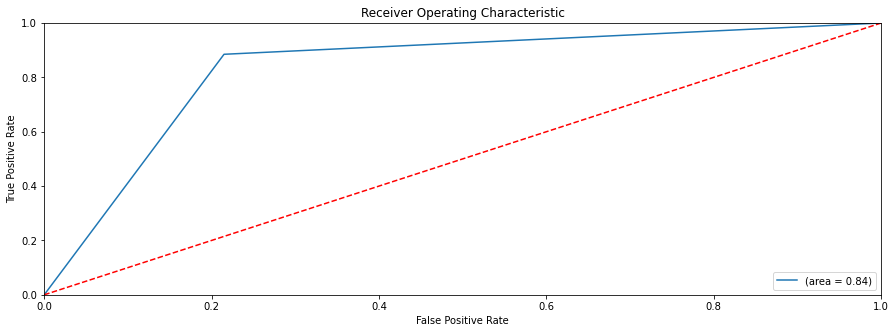

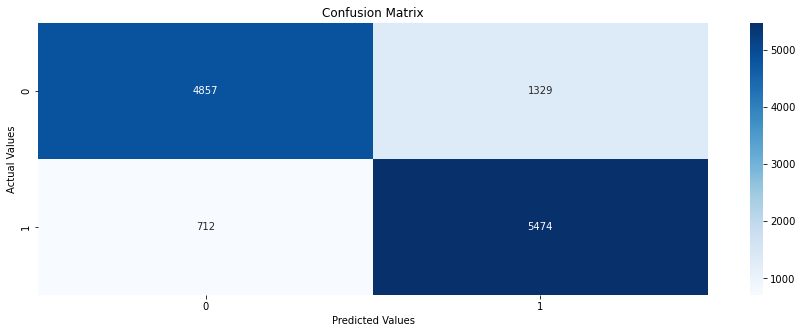

Model Train Time Taken: 64.11830615997314


In [14]:
accuracy,precision,recall,f1 = PerformanceMetric(Log_reg_grid_search,X_train,X_test,y_train,y_test,y_test_predict)
print('Model Train Time Taken:',time.time()-Start_time)
PerformanceResults.append(['Logistic Regression',accuracy,precision,recall,f1, time.time()-Start_time])

### 2. KNN

In [15]:
# grid searching key hyperparametres for KNeighborsClassifier
Start_time = time.time()

# define models and parameters
KNN = KNeighborsClassifier()
n_neighbors = range(1, 21, 2)
metric = ['euclidean', 'manhattan', 'minkowski']

# define grid search
grid = dict(n_neighbors=n_neighbors,metric=metric)

cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)

KNN_grid_search = GridSearchCV(estimator=KNN, param_grid=grid, n_jobs=-1, cv=cv, scoring='roc_auc',error_score=0)
KNN_grid_result = KNN_grid_search.fit(X_train, y_train)

# summarize results
print("Best: %f using %s" % (KNN_grid_result.best_score_, KNN_grid_result.best_params_))

# check recall on test set
y_test_predict = KNN_grid_result.predict(X_test)

Best: 0.907877 using {'metric': 'manhattan', 'n_neighbors': 19}


Testing Accuracy: 83.53 %
Testing Precision: 79.72 %
Testing Recall: 89.93 %
Testing F1 Score: 84.52 %


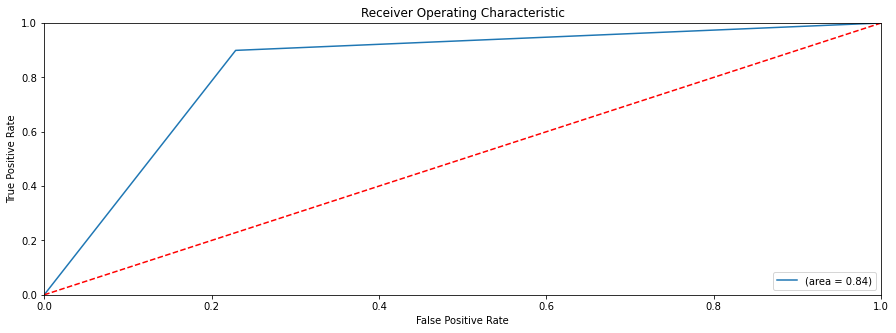

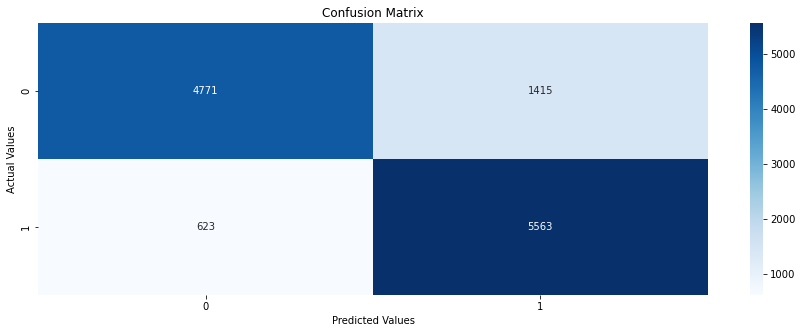

Model Train Time Taken: 255.39904832839966


In [16]:
accuracy,precision,recall,f1 = PerformanceMetric(KNN_grid_search,X_train,X_test,y_train,y_test,y_test_predict)
print('Model Train Time Taken:',time.time()-Start_time)
PerformanceResults.append(['K Neighbors Classifier',accuracy,precision,recall,f1,time.time()-Start_time])

### 3. Random Forest

In [17]:
# grid searching key hyperparameters for RandomForestClassifier
Start_time= time.time()

# define models and parameters
RF = RandomForestClassifier()
n_estimators = [5,10,15]
max_features = ['sqrt', 'log2']

# define grid search
grid = dict(n_estimators=n_estimators,max_features=max_features)

cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)

RF_grid_search = GridSearchCV(estimator=RF, param_grid=grid, n_jobs=-1, cv=cv, scoring='roc_auc',error_score=0)
RF_grid_result = RF_grid_search.fit(X_train, y_train)

# summarize results
print("Best: %f using %s" % (RF_grid_result.best_score_, RF_grid_result.best_params_))

# check recall on test set
y_test_predict = RF_grid_result.predict(X_test)

Best: 0.911630 using {'max_features': 'log2', 'n_estimators': 15}


Testing Accuracy: 84.47 %
Testing Precision: 84.14 %
Testing Recall: 84.97 %
Testing F1 Score: 84.55 %


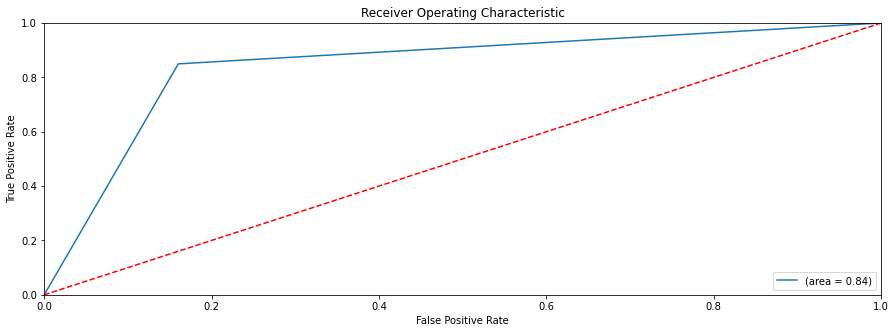

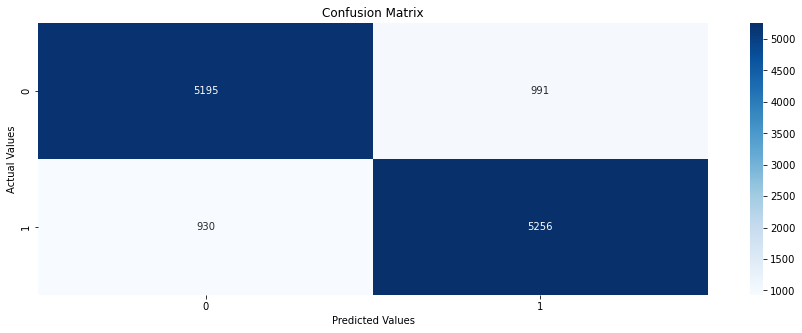

Model Train Time Taken: 10.084264755249023


In [18]:
accuracy,precision,recall,f1 = PerformanceMetric(RF_grid_search,X_train,X_test,y_train,y_test,y_test_predict)
print('Model Train Time Taken:',time.time()-Start_time)
PerformanceResults.append(['Random Forest Classifier',accuracy,precision,recall,f1,time.time()-Start_time])

### 4. Gradient Tree Boosting

In [19]:
#grid searching key hyperparameters for GradientBoostingClassifier

Start_time = time.time()
# define models and parameters
GB = GradientBoostingClassifier()
n_estimators = [5, 10, 15]
learning_rate = [0.001, 0.01, 0.1]

# define grid search
grid = dict(learning_rate=learning_rate, n_estimators=n_estimators)
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
GB_grid_search = GridSearchCV(estimator=GB, param_grid=grid, n_jobs=-1, cv=cv, scoring='roc_auc',error_score=0)
GB_grid_result = GB_grid_search.fit(X_train, y_train)

# summarize results
print("Best: %f using %s" % (GB_grid_result.best_score_, GB_grid_result.best_params_))

# check recall on test set
y_test_predict = GB_grid_result.predict(X_test)

Best: 0.908137 using {'learning_rate': 0.1, 'n_estimators': 15}


Testing Accuracy: 83.88 %
Testing Precision: 81.13 %
Testing Recall: 88.3 %
Testing F1 Score: 84.56 %


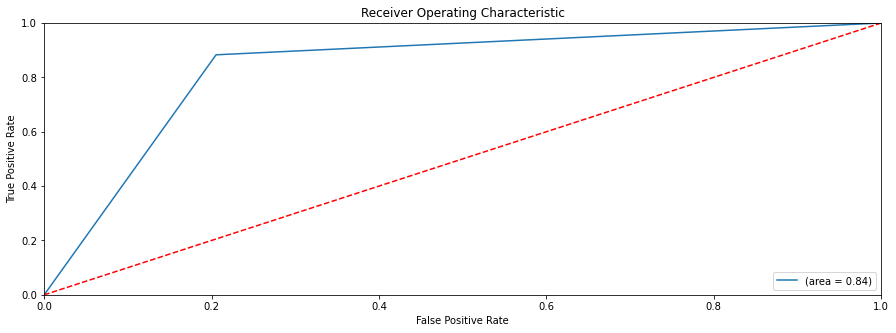

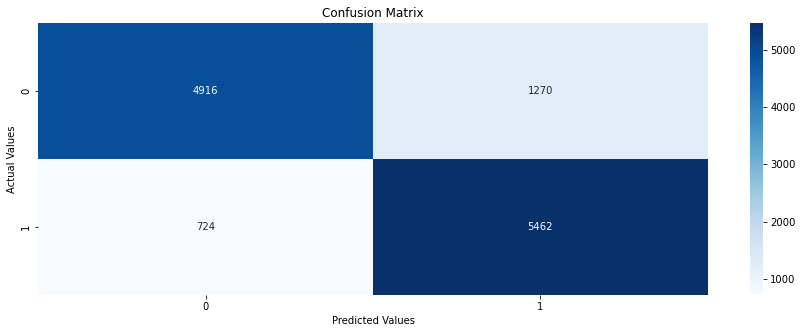

Model Train Time Taken: 16.101946592330933


In [20]:
accuracy,precision,recall,f1 = PerformanceMetric(GB_grid_search,X_train,X_test,y_train,y_test,y_test_predict)
print('Model Train Time Taken:',time.time()-Start_time)
PerformanceResults.append(['Gradient Boosting Classifier',accuracy,precision,recall,f1,time.time()-Start_time])

### 5. XGBoost

In [21]:
#grid searching key hyperparameters for GradientBoostingClassifier
Start_time = time.time()

# define models and parameters
XGB = XGBClassifier()

# A parameter grid for XGBoost
grid = {"learning_rate": (0.001, 0.01, 0.1),
        'min_child_weight': [1, 5, 10],
        'gamma': [ 0.0, 0.1, 0.2],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [ 0.3, 0.4],
        'max_depth': [3, 4, 5]
        }

# define grid search
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
XGB_grid_search = GridSearchCV(estimator=XGB, param_grid=grid, n_jobs=-1, cv=cv, scoring='roc_auc',error_score=0)
XGB_grid_result = XGB_grid_search.fit(X_train, y_train)

# summarize results
print("Best: %f using %s" % (XGB_grid_result.best_score_, XGB_grid_result.best_params_))

# check recall on test set
y_test_predict = XGB_grid_result.predict(X_test)

[14:19:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Best: 0.931716 using {'colsample_bytree': 0.3, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 1, 'subsample': 1.0}


Testing Accuracy: 85.47 %
Testing Precision: 85.77 %
Testing Recall: 85.05 %
Testing F1 Score: 85.41 %


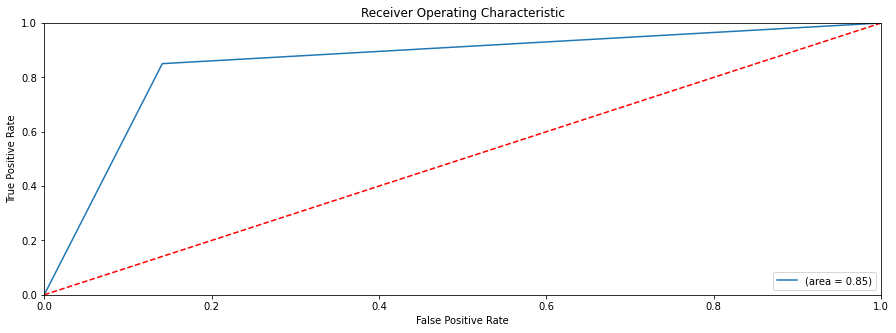

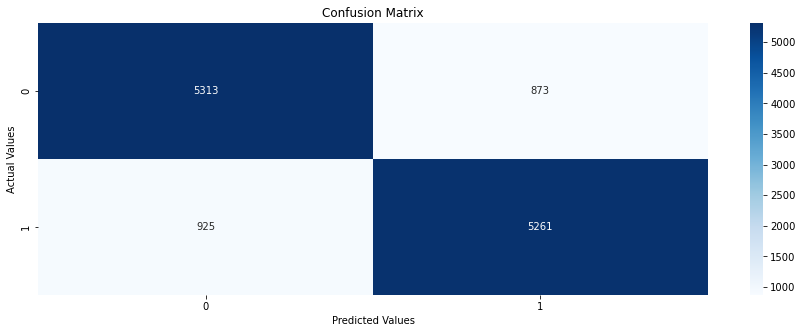

Model Train Time Taken: 4592.267809867859


In [22]:
accuracy,precision,recall,f1 = PerformanceMetric(XGB_grid_search,X_train,X_test,y_train,y_test,y_test_predict)
print('Model Train Time Taken:',time.time()-Start_time)
PerformanceResults.append(['XGBoost Classifier',accuracy,precision,recall,f1,time.time()-Start_time])

# Model Evaluation

In [23]:
Report = pd.DataFrame(PerformanceResults,columns=['Model','Accuracy','Precision','Recall','F1Score','TrainingTime'])
Report

,Model,Accuracy,Precision,Recall,F1Score,TrainingTime
0,Logistic Regression,0.835031,0.804645,0.884901,0.842867,64.118306
1,K Neighbors Classifier,0.835273,0.797220,0.899289,0.845184,255.399220
2,Random Forest Classifier,0.844730,0.841364,0.849661,0.845492,10.084265
3,Gradient Boosting Classifier,0.838830,0.811349,0.882962,0.845642,16.101947
4,XGBoost Classifier,0.854672,0.857679,0.850469,0.854058,4592.268787


# Model Assessment:
The XGBoost Classifier Model F1_score is high as compare to other model.
Therefore,XGBoost Classifier Model is the best model based on performance comparisons.

In [26]:
joblib.dump(XGB_grid_search,'US_Census_Bureau_income_level_classification_model.pkl')

['US_Census_Bureau_income_level_classification_model.pkl']

# Results: 

### summary of key findings

- The dataset might be suffering from selection bias:
    - The 83.88% of data belong to White Race People, where only 16.13% of data collected from other race.
    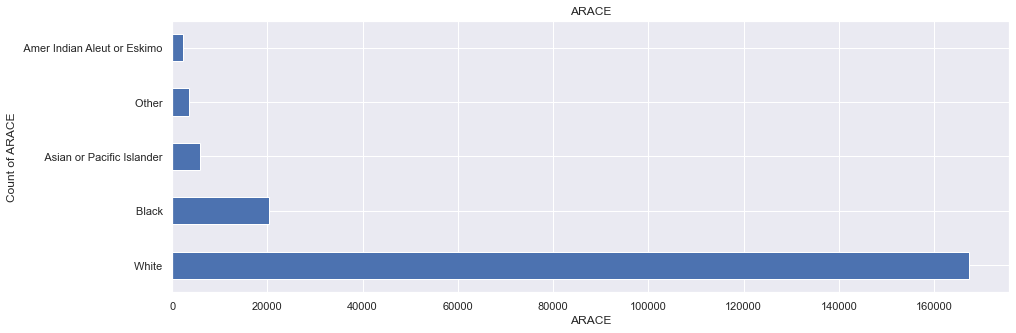
    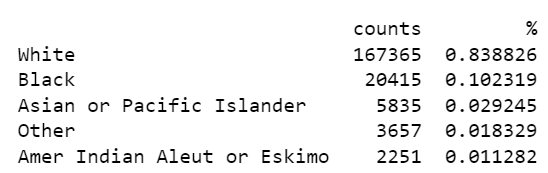
    
    - Many People in USA has 2 races as well. However, dataset included only one race.

- The dataset is extracted in 2019 - Current Population Survey by ASEC Technical.The data is 4 years old. Therefore, some of the facts might not be applicable now.
- Approximately 20,000 non-nterview households are present each month. This could be the reason 83.33% of data belong to White Race.


- AAGE: This variable defines "age of the Person". The Data has records for all person including who is not born or dead, Data included age range from 0 to 90. Where, 191237 people belong to 0-79 age group, 3214 people belong to 80-84 age group and 2233 has more than 85 age. Age data has right tail skewness (positive-skew distributions). And no outliers and No missing records detected in data.


- ACLSWKR: The data contains 9 types of class of worker with nominal data. This refers to the broad classification of the person's employer. these broad classifications for current jobs are Not in universe,Self-employed-not incorporated, Private, Local government,Federal government, Self-employed-incorporated, State government,Never worked,Without pay. Where, 98827 data records almost 50% of data belong to people who is "not in universe" and not contribute in income_level. Private and government workers has 98662 records and considered "wage and salary workers", which is 50% of the data.this includes private, Self-employed-not incorporated,Local government,State government,Self-employed-incorporated,Federal government,Without pay. On the other side, 165 workers only works without any pay and 438 people doesnot work. All Workers has more than 15 age expect "Not in universe". Therefore, Working minimum age is 15. The Highest Percentage of workers earns more than 50K belong to "Self-employed-incorporated". As compare to Government Jobs people prefer to the Private Jobs, Because people earns high pay in Private Jobs.


- AHGA: people has 17 distinct education categories in data. which includes Level of School Completed/Degree Received by person. The highest level of education is "Doctorate degree(PhD EdD)" completed by 1263 people, which is second least achieved education. The most people completed High school graduation, which is 24% of the data with 48374 people. Educational attainment applies only to progress in "regular" school.Such schools include graded public, private, and parochial elementary and high schools (both junior and senior high), colleges, universities, and professional schools, whether day schools or night schools. Thus, regular schooling is that which may advance a person toward an elementary school certificate or high school diploma, or a college, university, or professional school degree. Schooling in other than regular schools is counted only if the credits obtained are regarded as transferable to a school in the regular school system. Whereas, 12532 people enrolled in "High school" and "College or university". And 183762 people are enrolled in advance (non-born yet).More People earns more than 50K who has degree as compare the High school graduation or Dropout.


- AMARITL: 7 distinct types of marital status people holds in data.The marital status classified in four major categories: single (never married), married, widowed, and divorced. The category "married" is further divided into "married, civilian spouse present," "married, Armed Forces spouse present," "married, spouse absent," "married, Armed Forces spouse absent," and "separated." A person is classified as "married, spouse present" if the husband or wife is reported as a member of the household even though he or she may be temporarily absent on business or on vacation, visiting, in a hospital, etc., at the time of the enumeration. Persons reported as "separated"included those with legal separations, those living apart with intentions of obtaining a divorce, and other persons permanently or temporarily estranged from their spouses because of marital discord.The almost 43% people has Married-civilian spouse present and almost same % of people are not married. Whereas, 1517 people spouse are absent.	As compare to Single Person More people earns 50K+ income if spouse is present.


- AMJIND: Data includes 24 distict major industry code to define primary industry. Where almost 50% people are not in universe or children. Mining industry has most employees who earns more than 50K and Private Household services pay rarely 50K+.
- AMJOCC: Data includes 15 distict major occupation code to define primary occupation. Where almost 50% people are not in universe. highest Percentage of workers earns more than 50K as a Executive admin and manager.


- There is 5 types of race includes White, Black, Asian or Pacific Islander, Amer Indian Aleut or Eskimo and Other race. The last category includes any other race except the four mentioned. 84% of white people live in USA and only 1% population belong to "Amer Indian Aleut or Eskimo"

- AREORGN: data has 10 different Hispanic Origin on the basis of questionnaire. As compare to identified Origin, unidentified origin people is high, which is 86% of population, This includes All other, Do not Know, NA. The least Origin is Chicano.


- The female population is high as compare to the male population.Howerver, More male workers earn 50K+ income.


- People who has "Foreign born- U S citizen by naturalization" increases chance to earn more than 50K.

### recommendations

- Although we solved the problem successfully, we still have some extensions. For example, most variables in this dataset are categorical and some of them have many levels. I recommend to improve the performance of our models by using some suitable methods to reduce the number of levels for some categorical predictors before constructing predicted models.


### future improvements

- Apply PCA method. Whereas project uses lasso (L1 regularization) algorithm for "feature selection", which provides less scope of hyper parameter optimization.LASSO perform feature selection as the coefficients of predictors are shrunk towards zero. It still requires hyperparameter tuning because there is a regularization coefficient that weights how severe is the regularization of the loss function.

- Some features are not normally distributed. We can handle this issue using neural network or Artificial Intelligence approaches and they might have a better prediction performance than the current models.

- we only consider the relationship between income and the other covariates in this project. But the relationship between covariates might also be interesting, we can adopt graphical models to look into the dependence between predictors.